### Feather Soup 01 - Kalman

In [1]:
# Some general imports and set up
import matplotlib
%matplotlib inline

from datetime import timedelta
from datetime import datetime

import numpy as np

#### Simulate data

To start we'll create a simple truth path, with position at 1 second interval. This will represent an object moving constantly in both $x$ and $y$.

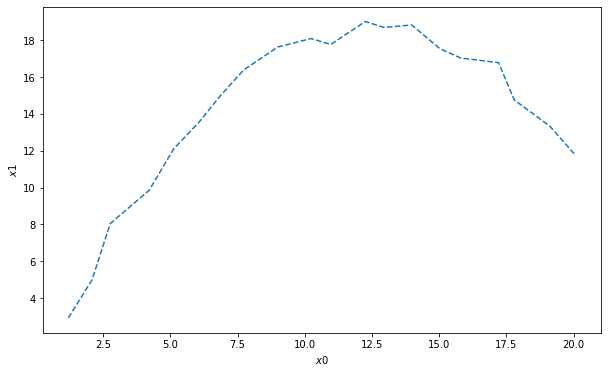

In [2]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

import pandas as pd


np.random.seed(seed=20)

start_time = datetime.now()
timepoints = 20

truth = []

for n in range(timepoints):
    x0 = n + 1
    x1 = -0.12 * (n + 1)**2 +  3 * (n + 1)
    varxy = [[0.05, 0], [0, 0.05]]
    x = np.random.multivariate_normal(np.array([x0, x1]), varxy)
    truth.append([start_time+timedelta(seconds=n), np.array([x[0], x[1]]) ])

df_truth = pd.DataFrame(truth, columns=['tp', 'mu'])

df_truth.head()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x0$")
ax.set_ylabel("$x1$")

ax.plot(
    df_truth.mu.map(lambda m: m[0]), 
    df_truth.mu.map(lambda m: m[1]), 
    linestyle="--"
)

#### Velocity:

As also the hidden observations are discrete, the velocity is approximated with difference vector of two consecutive timepoints $\Large(\frac{x_0^{(k+1)} - x_0^{(k)}}{\Delta t}, \frac{x_1^{(k+1)} - x_1^{(k)}}{\Delta t}\Large)$, in meters per seconds, relative reference frame.

In some real cases the velocities can be given as input, though they may be noisy measurements, in need of cleanup.

In [3]:
df_truth_speed = df_truth.copy()
num_points = df_truth_speed.shape[0]
for row in range(num_points-1):
    delta_t = (df_truth['tp'][row + 1] -  df_truth['tp'][row]).seconds
    df_truth_speed['mu'][row] = [
        (df_truth['mu'][row + 1][0] -  df_truth['mu'][row][0]) / delta_t,
        (df_truth['mu'][row + 1][1] -  df_truth['mu'][row][1]) / delta_t
    ]
    

df_truth_speed['mu'][num_points-1] = df_truth_speed['mu'][num_points-2]
df_truth_speed.head()

,tp,mu
0,2020-06-19 14:58:04.025851,"[0.8823030869301671, 2.0722339586212115]"
1,2020-06-19 14:58:05.025851,"[0.6774764636593535, 3.049121185995877]"
2,2020-06-19 14:58:06.025851,"[1.452647673850425, 1.8160530925266212]"
3,2020-06-19 14:58:07.025851,"[0.9024241404693774, 2.229672050436049]"
4,2020-06-19 14:58:08.025851,"[0.9598322072492618, 1.478792934772537]"


In [4]:
# ax.quiver(df_truth.mu.map(lambda m:m[0]), 
#           df_truth.mu.map(lambda m:m[1]), 
#           df_truth_speed.mu.map(lambda m:m[0]), 
#           df_truth_speed.mu.map(lambda m:m[1]),
#           color='g', alpha=0.4
# )

# fig

#### Observations

we simulate our measurements the hidden trajectory, using normal distribution with mean of the true position, with a covariance of $0.25$. The truth trajectory must be estimated from the observations.

In [5]:
from scipy.stats import multivariate_normal


observed = []


for _, row in df_truth.iterrows():
    x0, x1 = multivariate_normal.rvs([row.mu[0], row.mu[1]], cov=np.diag([0.75, 0.75]))
    observed.append([row.tp, [x0, x1], np.diag([0.75, 0.75]) ])

df_observed = pd.DataFrame(observed, columns=['tp', 'mu', 'sigma'])

df_observed.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[0.904503045981307, 3.2017656035491737]","[[0.75, 0.0], [0.0, 0.75]]"
1,2020-06-19 14:58:05.025851,"[1.5583335508531801, 6.333804711455532]","[[0.75, 0.0], [0.0, 0.75]]"
2,2020-06-19 14:58:06.025851,"[3.3177720126102908, 8.558893071041084]","[[0.75, 0.0], [0.0, 0.75]]"
3,2020-06-19 14:58:07.025851,"[4.589412074804055, 11.037084767523774]","[[0.75, 0.0], [0.0, 0.75]]"
4,2020-06-19 14:58:08.025851,"[6.155633236687785, 13.261566876750456]","[[0.75, 0.0], [0.0, 0.75]]"


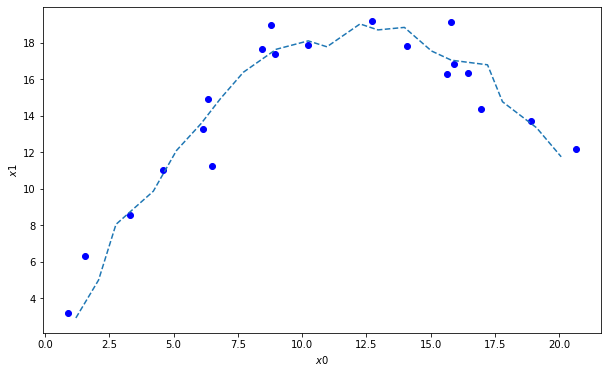

In [6]:
ax.scatter(df_observed.mu.map(lambda m:m[0]), df_observed.mu.map(lambda m:m[1]), color='b')
fig

### Create Models and Kalman Filter

Now we have our measurements, which you can see against the true path in the plot above, we'll begin creating our Kalman Filter.

Unlike stone soup where velocity and positions are embedded in the same structure, we keep them separate, as in the two pandas dataframe provided above.

For input values the vector of observations $z$ with their estimated errors the first prior $p_0$ and the first estimated velocity $v$.

The elements $z$, $p$ and $u$ are vectors of random variables, each defined by a mean and a standard deviation, or a mean vector and covariance matrix. 


| $k$      | $z$ obs.  | $p$ prior     | update          | $\hat{u}$                                      | prediction                        |
|------    |:------    |:------        |:-----           |:-----                                          |:-----                             | 
| $0$      | $z_0$     | $p_0$ (input) | $z_0 \star p_0$ | $\hat{u}_0$ (input)                            | $z_0 \star p_0 + \hat{u}_0 = p_1$ |
| $1$      | $z_1$     | $p_1$         | $z_1 \star p_1$ | $p_1 + \frac{p_0 + p_1}{\Delta t} = \hat{u}_1$ | $z_1 \star p_1 + \hat{u}_1 = p_2$ |
| $2$      | $z_2$     | $p_2$         | $z_2 \star p_2$ | $p_2 + \frac{p_1 + p_2}{\Delta t} = \hat{u}_2$ | $z_2 \star p_2 + \hat{u}_2 = p_3$ |
| $3$      | $z_3$     | $p_3$         | $z_2 \star p_2$ | $p_3 + \frac{p_2 + p_1}{\Delta t} = \hat{u}_3$ | $z_3 \star p_3 + \hat{u}_3 = p_4$ |
| $\vdots$ | $\vdots$  | $\vdots$      | $\vdots$        | $\vdots$                                       | $\vdots$                          |

Preparing the tables for prior, update, speed and prediction:

In [7]:
df_prior = df_observed.copy()

df_prior.mu = [[1.2, 2.9] ] + [np.nan, ] * (df_prior.shape[0] -1) 
df_prior.sigma = [ [[1.0, 0], [0, 1.0]] ] * (df_prior.shape[0]) 


df_prior.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[1.2, 2.9]","[[1.0, 0], [0, 1.0]]"
1,2020-06-19 14:58:05.025851,NaN,"[[1.0, 0], [0, 1.0]]"
2,2020-06-19 14:58:06.025851,NaN,"[[1.0, 0], [0, 1.0]]"
3,2020-06-19 14:58:07.025851,NaN,"[[1.0, 0], [0, 1.0]]"
4,2020-06-19 14:58:08.025851,NaN,"[[1.0, 0], [0, 1.0]]"


In [8]:
df_update = df_observed.copy()

df_update.mu = np.nan
df_update.sigma = np.nan
# Caveat to allow for tuple assignment
df_update = df_update.astype({"mu": object, "sigma": object})

df_update.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,NaN,NaN
1,2020-06-19 14:58:05.025851,NaN,NaN
2,2020-06-19 14:58:06.025851,NaN,NaN
3,2020-06-19 14:58:07.025851,NaN,NaN
4,2020-06-19 14:58:08.025851,NaN,NaN


In [9]:
df_speed = df_observed.copy()

df_speed.mu = np.nan
df_speed = df_update.astype({"mu": object})  # Caveat to allow for tuple assignment
df_speed.sigma = [ [[.5, 0], [0, .5]] ] * (df_prior.shape[0]) 

df_speed.mu[0] = [.8, 1.5]

df_speed.head()


,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[0.8, 1.5]","[[0.5, 0], [0, 0.5]]"
1,2020-06-19 14:58:05.025851,NaN,"[[0.5, 0], [0, 0.5]]"
2,2020-06-19 14:58:06.025851,NaN,"[[0.5, 0], [0, 0.5]]"
3,2020-06-19 14:58:07.025851,NaN,"[[0.5, 0], [0, 0.5]]"
4,2020-06-19 14:58:08.025851,NaN,"[[0.5, 0], [0, 0.5]]"


In [10]:
df_prediction = df_observed.copy()

df_prediction.mu = np.nan
df_prediction.sigma = np.nan
df_prediction = df_update.astype({"mu": object, "sigma": object})

df_prediction.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,NaN,NaN
1,2020-06-19 14:58:05.025851,NaN,NaN
2,2020-06-19 14:58:06.025851,NaN,NaN
3,2020-06-19 14:58:07.025851,NaN,NaN
4,2020-06-19 14:58:08.025851,NaN,NaN


### Compute the kalman filter for all the values

In [11]:
"""
An observation is a triplet (time, mu, sigma), where mu is a nd vector and 
sigma is an nd x nd matrix.
They are usually encoded as a row of a dataframe.    
"""


def observations_product(mu1, sigma1, mu2, sigma2):
    """
    Returns the multivariate product of gaussians.
    """
    mu1 = np.array(mu1)
    mu2 = np.array(mu2)
    sigma1 = np.array(sigma1)
    sigma2 = np.array(sigma2)

    inv = np.linalg.inv(np.array(sigma1) + np.array(sigma2))
    mu = sigma2 @ inv @ mu1 + sigma1 @ inv @ mu2
    sigma = sigma1 @ inv @ sigma2
    return (mu,  sigma)


def observations_sum(mu1, sigma1, mu2, sigma2, smoothing=.5):
    """
    Returns the sum of the observation within the uncertainty, whith sigma smoothed by an input factor (default 0).
    """
    return (np.array(mu1) + np.array(mu2), smoothing * (np.array(sigma1) + np.array(sigma2)))

In [12]:
df_update.mu[0], df_update.sigma[0] = observations_product(
    df_observed.mu[0], df_observed.sigma[0], df_prior.mu[0], df_prior.sigma[0]
)
df_update.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[1.0311445977036038, 3.072437487742385]","[[0.42857142857142855, 0.0], [0.0, 0.428571428..."
1,2020-06-19 14:58:05.025851,NaN,NaN
2,2020-06-19 14:58:06.025851,NaN,NaN
3,2020-06-19 14:58:07.025851,NaN,NaN
4,2020-06-19 14:58:08.025851,NaN,NaN


In [13]:
df_prediction.mu[0], df_prediction.sigma[0] = observations_sum(
    df_prior.mu[0], df_prior.sigma[0], df_speed.mu[0], df_speed.sigma[0]
)
df_prediction.head()

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[2.0, 4.4]","[[0.75, 0.0], [0.0, 0.75]]"
1,2020-06-19 14:58:05.025851,NaN,NaN
2,2020-06-19 14:58:06.025851,NaN,NaN
3,2020-06-19 14:58:07.025851,NaN,NaN
4,2020-06-19 14:58:08.025851,NaN,NaN


In [14]:
import time

start = time.perf_counter()

for row in range(1, df_observed.shape[0]):
    df_prior.mu[row], df_prior.sigma[row] = df_prediction.mu[row-1], df_prediction.sigma[row-1]

    df_update.mu[row], df_update.sigma[row] = observations_product(
        df_observed.mu[row], df_observed.sigma[row], df_prior.mu[row], df_prior.sigma[row]
    )

    delta_t = (df_speed.tp[row] -  df_truth.tp[row-1]).seconds
    df_speed.mu[row] = (
        (np.array(df_update.mu[row]) + np.array(df_observed.mu[row]) )/2 - np.array(df_update.mu[row - 1])
    )/ delta_t 
    df_speed.sigma[row] = np.array(df_update.sigma[row]) + np.array(df_update.sigma[row - 1])

    df_prediction.mu[row], df_prediction.sigma[row] = observations_sum(
        df_prior.mu[row], df_prior.sigma[row], df_speed.mu[row], df_speed.sigma[row]
    )

stop = time.perf_counter()

print("computational time", stop - start)

computational time 0.05790455895476043


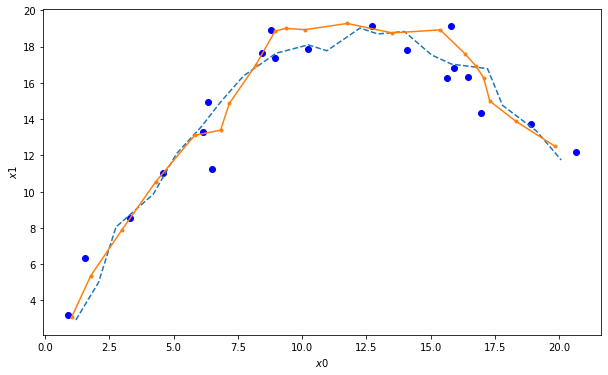

In [15]:
ax.plot(
    df_update.mu.map(lambda m:m[0]), 
    df_update.mu.map(lambda m:m[1]),
    marker="."
)

fig

In [16]:
df_update

,tp,mu,sigma
0,2020-06-19 14:58:04.025851,"[1.0311445977036038, 3.072437487742385]","[[0.42857142857142855, 0.0], [0.0, 0.428571428..."
1,2020-06-19 14:58:05.025851,"[1.77916677542659, 5.366902355727766]","[[0.375, 0.0], [0.0, 0.375]]"
2,2020-06-19 14:58:06.025851,"[2.9836551613669178, 7.880518391999488]","[[0.381578947368421, 0.0], [0.0, 0.38157894736..."
3,2020-06-19 14:58:07.025851,"[4.302473429506458, 10.539436714223182]","[[0.379124709527498, 0.0], [0.0, 0.37912470952..."
4,2020-06-19 14:58:08.025851,"[5.816631237103438, 13.101475741587162]","[[0.3783922814724542, 0.0], [0.0, 0.3783922814..."
5,2020-06-19 14:58:09.025851,"[6.825077300656853, 13.38880411242608]","[[0.3776326353887669, 0.0], [0.0, 0.3776326353..."
6,2020-06-19 14:58:10.025851,"[7.166892633439716, 14.860516713914183]","[[0.3770672791068172, 0.0], [0.0, 0.3770672791..."
7,2020-06-19 14:58:11.025851,"[8.194341188993063, 16.97937388662423]","[[0.3766198313450322, 0.0], [0.0, 0.3766198313..."
8,2020-06-19 14:58:12.025851,"[8.943758353555456, 18.843164307186726]","[[0.3762700024288486, 0.0], [0.0, 0.3762700024..."
9,2020-06-19 14:58:13.025851,"[9.357588993683224, 19.001142101840976]","[[0.3759957372658578, 0.0], [0.0, 0.3759957372..."
